In [1]:
import sys
sys.path.append('/home/ubuntu/datalab/github/')

In [2]:
from torchsimple import *

In [54]:
class MnistDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        res = {}
        res['inputs'] = self.dataset[index][0]
        res['targets'] = self.dataset[index][1]
        return res

In [55]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=False, train=True, transform=transform)
trainset = MnistDataset(trainset)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)

# Download and load the test data
validationset = datasets.FashionMNIST('./data', download=False, train=False, transform=transform)
validationset = MnistDataset(validationset)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True, drop_last=True)

## Load data

In [56]:
dataowner =  DataOwner(train_loader, trainset, val_loader, validationset, None, None)

## Models

In [57]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

In [58]:
model = CNN()

## Criterion

In [59]:
criterion = nn.NLLLoss()

In [60]:
def step_fn(state):
    """Determine what your model will do with your data.

    Args:
        model: the pytorch module to pass input in
        batch: the batch of data from the DataLoader

    Returns:
        The models forward pass results
    """
    model, batch = state.model, state.batch
    input = batch["inputs"]
    if state.use_fp16:
        input = input.half()
    out = model(input)
    if isinstance(out, torch.Tensor):
        out = out.float()
    return out

## Callback

In [61]:
class DefaultLossCallback(Callback):
    """
    A callback to calculate loss by default.
    If a loss is not precised during fit of training, this callback will be 
    used for the loss of model.
    """
    def __init__(self, target_key: str, preds_key: str) -> None:
        self.target_key = target_key
        self.preds_key = preds_key

    def on_batch_end(self, i: int, state: DotDict) -> None:
        target = state.batch[self.target_key]
        preds = state.out[self.preds_key]
        state.loss = state.criterion(preds, target)

## Train

In [62]:
learner = Trainer(model=model,
                  dataowner=dataowner,
                  criterion=criterion, 
                  step_fn=step_fn,
                  opt=optim.Adam,
                  target_key='targets',
                  preds_key='preds',
                  opt_params={'lr' : 0.001,
                              'betas' : (0.9, 0.999)},
                  device='cuda')

TRAIN | Epoch 1/1:  19% 177/937 [00:02<00:12, 60.12it/s, loss=14.2834]


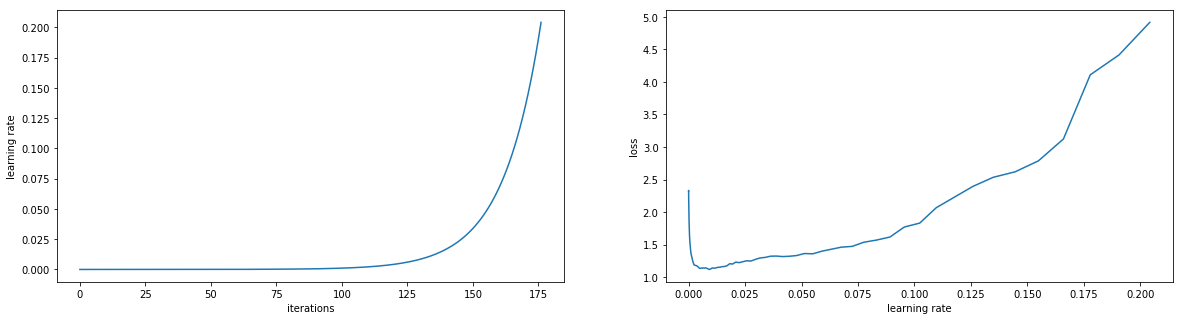

In [63]:
# set_trace()
learner.find_lr(final_lr=1,
                n_steps=200)

In [64]:
learner.fit_one_cycle(max_lr=1e-3,
                      cycle_len=3,
                      logdir='saved/logdir/fashsion_mnist',
                      cp_saver_params= {'savedir' : 'saved/checkpoint/fashsion_mnist'},
                      use_fp16=True)

TRAIN | Epoch 1/3: 100% 937/937 [00:17<00:00, 54.89it/s, loss=0.3963]
VALID | Epoch 1/3: 100% 156/156 [00:02<00:00, 74.21it/s, loss=0.4163, val_loss=0.4090]
TRAIN | Epoch 2/3: 100% 937/937 [00:17<00:00, 54.59it/s, loss=0.2434]
VALID | Epoch 2/3: 100% 156/156 [00:02<00:00, 72.88it/s, loss=0.2990, val_loss=0.2835]
TRAIN | Epoch 3/3: 100% 937/937 [00:17<00:00, 54.53it/s, loss=0.2201]
VALID | Epoch 3/3: 100% 156/156 [00:02<00:00, 73.22it/s, loss=0.2620, val_loss=0.2457]

Checkpoint	val_loss
saved/checkpoint/fashsion_mnist/checkpoint.epoch_3.h5	0.245701
saved/checkpoint/fashsion_mnist/checkpoint.epoch_2.h5	0.283504
saved/checkpoint/fashsion_mnist/checkpoint.epoch_1.h5	0.409046
